<a href="https://colab.research.google.com/github/Diachrony/molecular-vae/blob/master/Molecular_VAE_w_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas as pd
import h5py
import numpy as np
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection

In [2]:
# Load from a checkpoint if wanted
LOAD_FROM_CHECKPOINT = True
RUN_ON_TEST_DATA = True
GENERATE_LATENT_SPACE_SMILES = True
EVAL_OTHER_SMILES = True

# Needed for training the model, or, if loading from a checkpoint, to know the charset, data_test, etc.
data_file_to_load_from = './data/processed_4330_150_43.h5'

# Checkpoint and data file should have matching data signatures
# If you change the model (layer sizes, etc.) the checkpoints may not load if they don't match
# Only used if loading from checkpoint file is True
checkpoint_path = './data/checkpoints/5000_checkpoint_4330_150_43.pt'

checkpoint_frequency = 10

epochs = 10000 # 10000 on a100 gpu is good



In [3]:
checkpoint_signature = '_'.join(checkpoint_path.split('.')[-2].split('/')[-1].split('_')[2:])
data_file_signature = '_'.join(data_file_to_load_from.split('.')[-2].split('/')[-1].split('_')[1:])

data_signature = data_file_signature if LOAD_FROM_CHECKPOINT else checkpoint_signature
print(f'Data signature: {data_signature}')

input_len = int(data_signature.split('_')[1])
charset_len = int(data_signature.split('_')[2])
print(f'Input length: {input_len}, Charset length: {charset_len}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
torch.manual_seed(42)


Data signature: 1616_42_41
Input length: 42, Charset length: 41
Using device: cuda


In [4]:
def one_hot_array(i, n):
    return map(int, [ix == i for ix in range(n)])

def one_hot_index(vec, charset):
    return map(charset.index, vec)

def from_one_hot_array(vec):
    oh = np.where(vec == 1)
    if oh[0].shape == (0, ):
        return None
    return int(oh[0][0])

def decode_smiles_from_indexes(vec, charset):
    return "".join(map(lambda x: charset[x], vec)).strip()

def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    data_train = h5f['data_train'][:]
    data_test = h5f['data_test'][:]
    if not split:
        # data_test is combined data_test and data_train
        data_test = np.concatenate((data_test, data_train), axis=0)
        data_train = None

    charset =  h5f['charset'][:]
    h5f.close()

    charset = [ch.decode("utf-8") if isinstance(ch, bytes) else ch for ch in charset]


    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)


In [5]:
class MolecularVAE(nn.Module):
    def __init__(self, charset_length=33, input_len=120): #
        super(MolecularVAE, self).__init__()

        self.input_len = input_len

        self.conv_1 = nn.Conv1d(input_len, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)

        # Calculate the size after convolution operations
        L = charset_length
        L = (L - 9 + 1)  # after conv_1
        L = (L - 9 + 1)  # after conv_2
        L = (L - 11 + 1)  # after conv_3

        self.linear_0 = nn.Linear(10*L, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, charset_length)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=2)

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.input_len, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar


In [6]:
#!rm -R 'molecular-vae'
#!git clone https://github.com/aksub99/molecular-vae.git
#import zipfile
#zip_ref = zipfile.ZipFile('molecular-vae/data/processed.zip', 'r')
#zip_ref.extractall('molecular-vae/data/')
#zip_ref.close()


In [7]:
def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    xent_loss = F.binary_cross_entropy(x_decoded_mean, x, size_average=False)
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return xent_loss + kl_loss

data_train, data_test, charset = load_dataset(data_file_to_load_from)
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)

print(f'Charset length: {charset_len}', type(charset_len))
print(f'Input length: {input_len}', type(input_len))
model = MolecularVAE(charset_length=charset_len, input_len=input_len).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)


Charset length: 41 <class 'int'>
Input length: 42 <class 'int'>


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:

# Create checkpoints directory if it doesn't exist
if not os.path.exists('data/checkpoints'):
    os.makedirs('data/checkpoints')

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()
        output, mean, logvar = model(data)

        if batch_idx==0 and epoch % checkpoint_frequency == 0:
              inp = data.cpu().numpy()
              outp = output.cpu().detach().numpy()
              lab = data.cpu().numpy()
              print("Epoch:", epoch)
              print("Input:")
              print(decode_smiles_from_indexes(map(from_one_hot_array, inp[0]), charset))
              print("Label:")
              print(decode_smiles_from_indexes(map(from_one_hot_array, lab[0]), charset))
              sampled = outp[0].reshape(1, input_len, len(charset)).argmax(axis=2)[0]
              print("Output:")
              print(decode_smiles_from_indexes(sampled, charset))
              # save checkpoint
              torch.save(model.state_dict(), f'data/checkpoints/{epoch}_checkpoint_{data_signature}.pt')

        loss = vae_loss(output, data, mean, logvar)
        loss.backward()
        train_loss += loss
        optimizer.step()
#         if batch_idx % 100 == 0:
#             print(f'{epoch} / {batch_idx}\t{loss:.4f}')
    print('train', train_loss / len(train_loader.dataset))
    return train_loss / len(train_loader.dataset)


In [9]:

if LOAD_FROM_CHECKPOINT:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
else:
    for epoch in range(1, epochs + 1):
        train_loss = train(epoch)

    # Get highest numberd checkpoint with this data signature from the checkpoints directory
    checkpoints = os.listdir('data/checkpoints')
    checkpoints = [c for c in checkpoints if data_signature in c]
    checkpoints = [c.split('_')[0] for c in checkpoints]
    last_checkpoint = max([int(c) for c in checkpoints])

    model.load_state_dict(torch.load(f'data/checkpoints/{last_checkpoint}_checkpoint_{data_signature}.pt', map_location=torch.device('cpu')))

<ipython-input-9-38348bd50800>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


In [10]:
!pip install rdkit

In [11]:
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from IPython.display import display

def calculate_mol_metrics(smiles):
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    valid = [1 if m else 0 for m in mols]
    print(f'Num valid: {sum(valid)}')
    frac_valid = sum(valid) / len(valid)
    mol_wt = [Descriptors.MolWt(m) for m in mols if m]
    avg_mol_wt = sum(mol_wt) / len(mol_wt)
    return frac_valid, avg_mol_wt


In [12]:
def test_data (data_test):
    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)
    output, _, _ = model(data_test)

    # Decode the output
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # print the first 10 decoded SMILES and the test data
    for i in range(10):
        print(decoded[i])
        print(decode_smiles_from_indexes(map(from_one_hot_array, data_test[i].cpu().numpy()), charset))
        print()

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')

    frac_valid, avg_mol_wt = calculate_mol_metrics(decoded)
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')


    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    print([d for d in decoded if Chem.MolFromSmiles(d)])
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)


COc1cc(/c1)c(N)Nc2C)N)(N)()))CC(C(N)cc1
CN(C)c1ncnc2c1ncn2CCn1cnc2ncnc(N(C)C)c21

C1CCCC3CC)OOOC(CCCCC1OCO
CC1OC2(CS1)CN1CCC2CC1.Cl.O

CCOC)CO)c1nnn=C)CC/C==)=O)NO=
CCOC(=O)CC/N=C(\N)N=C(N)N.Cl.Cl

CC1CC(CNCCCCC((c2ccccccc2))C1CC12
CN1CC=C(C=Cc2c[nH]c3ccccc23)CC1

CCCCCCCCCCCCCCC@CC@()O)CC@]](O)CC@((=))
CCCCCCCCCCCCC[C@@H](O)C[C@@H](O)[C@H](C)N

COc1cccccnNCC(((ccc(c3)ccc)))cc
COc1ccc2nc(NC(=O)Nc3ccccc3)sc2c1

C1CCC2CCCCCCCCC1CCCCCCCCOO
C1CCC2(CC1)COC1(CCCCC1)OC2

O=C([N11CC(Cc1OOc2cccco()cc1))c1cccc1r
O=C(CN1CCN(C(=O)c2ccco2)CC1)Nc1ccccc1Br

O=C((C(=OOcccccccc1cccccccc1
O=C(/C=C\Nc1ccccn1)c1ccc(Cl)cc1

CC1C(C(C)CO)Cc1cc((l)ccc1O
CN(C)C(=O)CCNc1ccc(Br)cc1

Num valid: 15
Fraction of valid molecules: 0.046296296296296294
Average molecular weight: 201.70319999999998
['NCCCNCC', 'CCCCCCCCCCCCCCCCCCC', 'CCCCCCCc1ccc(O)nc1OO', 'CC(Cc1ccccc1)CCCCCl.Cl', 'COC1=CC(=O)C=CC(C)C1=O', 'O=C1Nc2ccc(F)cc2C1=O', 'N 1.r', 'O=C(O)c1ccc(O)1', 'O=C1CCCC1O', 'CCCCCC/CCCCCCCCC(=O)O', 'OOC(OO)N(N)CS', 'OCP(O)

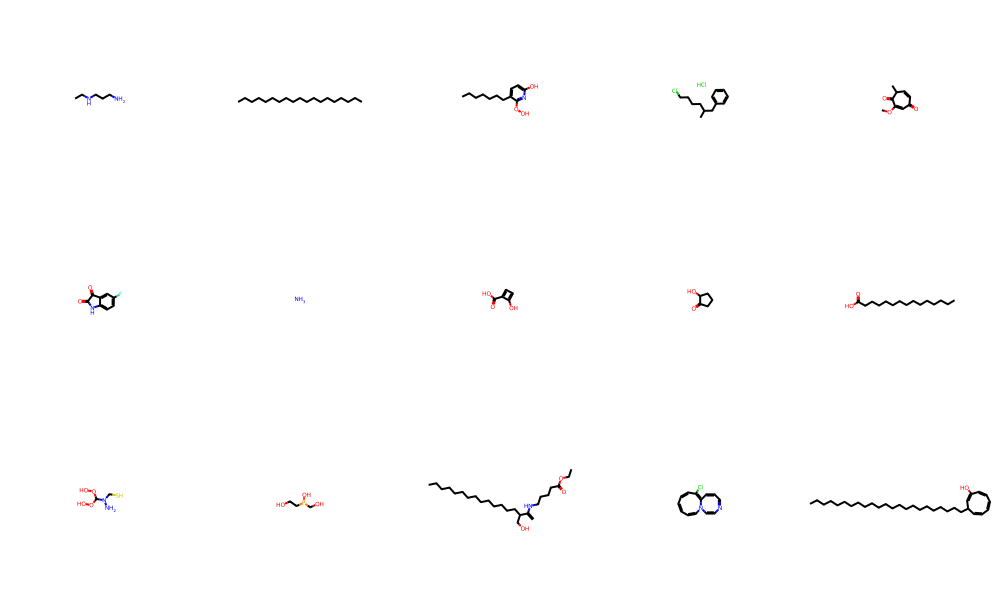

In [13]:
if RUN_ON_TEST_DATA:
    test_data(data_test)

In [14]:

# Suggest new molecules from latent space, validate, and calculate metrics
def suggest_molecules(model, num_mols=1000):
    z = torch.randn(num_mols, 292).to(device)
    output = model.decode(z)
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        # get charset in correct format from array of strings
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    frac_valid, avg_mol_wt = calculate_mol_metrics(decoded)
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')

    # Draw the first 10 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
    print([d for d in decoded if Chem.MolFromSmiles(d)])
    dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
    display(dr_mol)

    return decoded

Num valid: 13
Fraction of valid molecules: 0.013
Average molecular weight: 250.38807692307688
['OCC(COCCCII)S', 'BOc1ccc(C)c(CO)CCc1', 'CCCCCCC=CCCCCCCCCC', 'CC(CNC2CCc2CC(CC)1)CC1', 'CCCCCCCCCCCCCCC(CC)O', 'CCCc1ccnc2c(s(Cc1c2)C)CCO.Cl', 'O=C(OOc1OOOCOOO)c1', 'CCNCCCCCCCC', 'CCCCCCCCCCCCCCCCCCCCCCOOC', 'N', 'CCCCCCCCCCCCCCCSS=CCCCCCCC', 'COc1ccc(CC)CCCCCCCCCC(C)cc1', 'C=CC1cc(CCCCCC)CCCCCCCCcc1']


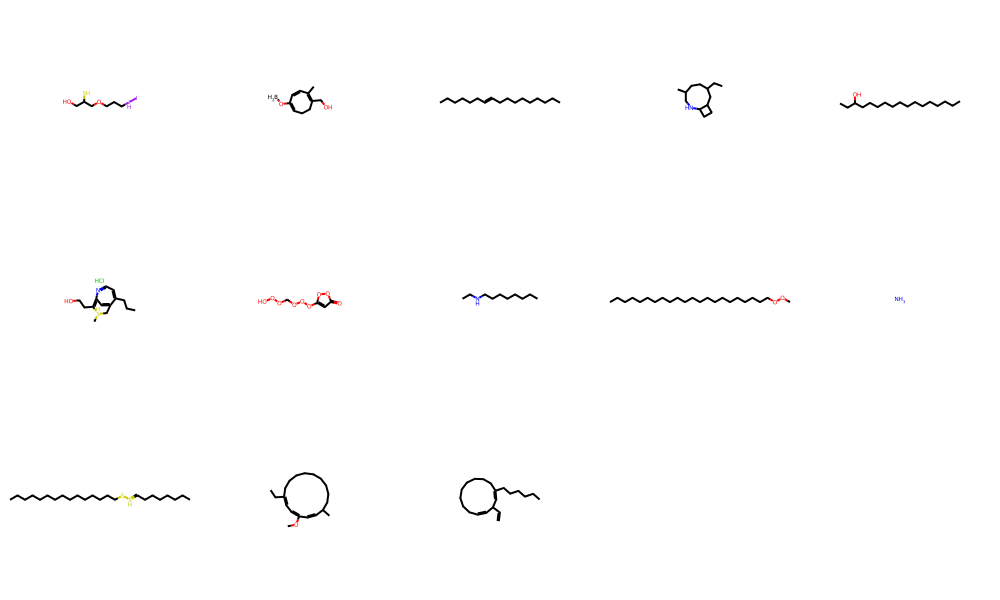

In [15]:
if GENERATE_LATENT_SPACE_SMILES:
    # suggest new molecules and calculate metrics
    suggest_molecules(model)



In [16]:
# Predict smiles based on these external smiles as input
# Use model to predict and then evaluate the predicted molecules
import data_preprocessing as dp

# Evaluate other Smiles generated from external sources using this model
# Vocab must be less than or equal to charset_len for this model

def display_sample_smiles(smiles_file_path):

    # import sample smiles from SMILES_Dataset.csv
    smiles_data = pd.read_csv(smiles_file_path, header=0)
    # remove empty rows
    smiles_data = smiles_data.dropna()

    # evaluate sample smiles for validity and molecular weight
    frac_valid, avg_mol_wt = calculate_mol_metrics(smiles_data['Smiles'])
    print(f'Fraction of valid molecules: {frac_valid}')
    print(f'Average molecular weight: {avg_mol_wt}')

    # Draw the first 20 valid molecules
    valid_mols = [Chem.MolFromSmiles(s) for s in smiles_data['Smiles'] if Chem.MolFromSmiles(s)]
    print(f"Valid smiles: {[d for d in smiles_data['Smiles'] if Chem.MolFromSmiles(d)]}")
    dr_mol = Draw.MolsToGridImage(valid_mols[:40], molsPerRow=5, subImgSize=(200, 200))
    print('Displaying input Sample Smiles: ')
    display(dr_mol)

    # send in charset_len
    # get h5 file from data_preprocessing
    data_path = dp.original_csv_to_ohe_h5(smiles_file_path, max_smiles_len=input_len, charset=charset)

    # load the data
    data_test, _ = load_dataset(data_path, split=False)

    # Use to predict from data_test
    if type(data_test) == np.ndarray:
        data_test = torch.from_numpy(data_test)
    elif type(data_test) == h5py.Dataset:
        data_test = torch.from_numpy(np.array(data_test))
    elif type(data_test) == torch.Tensor:
        data_test = torch.from_numpy(data_test.numpy()).float()
    else:
        data_test = data_test.float()

    data_test = data_test.to(device)

    output, _, _ = model(data_test)
    out = output.cpu().detach().numpy()
    out = out.reshape(out.shape[0], input_len, charset_len).argmax(axis=2)
    decoded = []
    for i in range(out.shape[0]):
        decoded.append(decode_smiles_from_indexes(map(int, out[i]), charset))

    # print the first 10 decoded SMILES and the test data
        print()
        print(f'Original: {smiles_data["Smiles"].iloc[i]}')
        print(f'Predicted: {decoded[i]}')

    # calculate performance metrics
    rdBase.DisableLog('rdApp.*')
    try:
        frac_valid, avg_mol_wt = calculate_mol_metrics(decoded)
        print(f'Fraction of valid molecules: {frac_valid}')
        print(f'Average molecular weight: {avg_mol_wt}')

        # Draw the first 10 valid molecules
        valid_mols = [Chem.MolFromSmiles(s) for s in decoded if Chem.MolFromSmiles(s)]
        print([d for d in decoded if Chem.MolFromSmiles(d)])
        dr_mol = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200, 200))
        print('Displaying Model Predicted Smiles from Sample Smiles as input:')
        display(dr_mol)
    except ZeroDivisionError:
        print('No valid molecules found')




Num valid: 87
Fraction of valid molecules: 0.435
Average molecular weight: 321.1419770114944
Valid smiles: ['O=C1NC(=O)C2(c3cc(F)c(F)cc3)CC12', 'O=C1NC(=O)C2(c3cc(F)c(Cl)cc3)CC12', 'O=C1NC(=O)C2(c3cc(F)c(Br)cc3)CC12', 'O=C1NC(=O)C2(c3cc(F)c(I)cc3)CC12', 'O=C1NC(=O)C2(c3cc(F)c(OC)cc3)CC12', 'O=C1NC(=O)C2(c3cc(F)c(CN)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Cl)c(F)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Cl)c(Cl)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Cl)c(Br)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Cl)c(I)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Cl)c(CN)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Cl)c(OC)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Br)c(F)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Br)c(Cl)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Br)c(Br)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Br)c(I)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Br)c(CN)cc3)CC12', 'O=C1NC(=O)C2(c3cc(Br)c(OC)cc3)CC12', 'O=C1NC(=O)C2(c3cc(I)c(F)cc3)CC12', 'O=C1NC(=O)C2(c3cc(I)c(Cl)cc3)CC12', 'O=C1NC(=O)C2(c3cc(I)c(Br)cc3)CC12', 'O=C1NC(=O)C2(c3cc(I)c(I)cc3)CC12', 'O=C1NC(=O)C2(c3cc(I)c(CN)cc3)CC12', 'O=C1NC(=O)C2(c3cc(I)c(OC)cc3)CC12', 

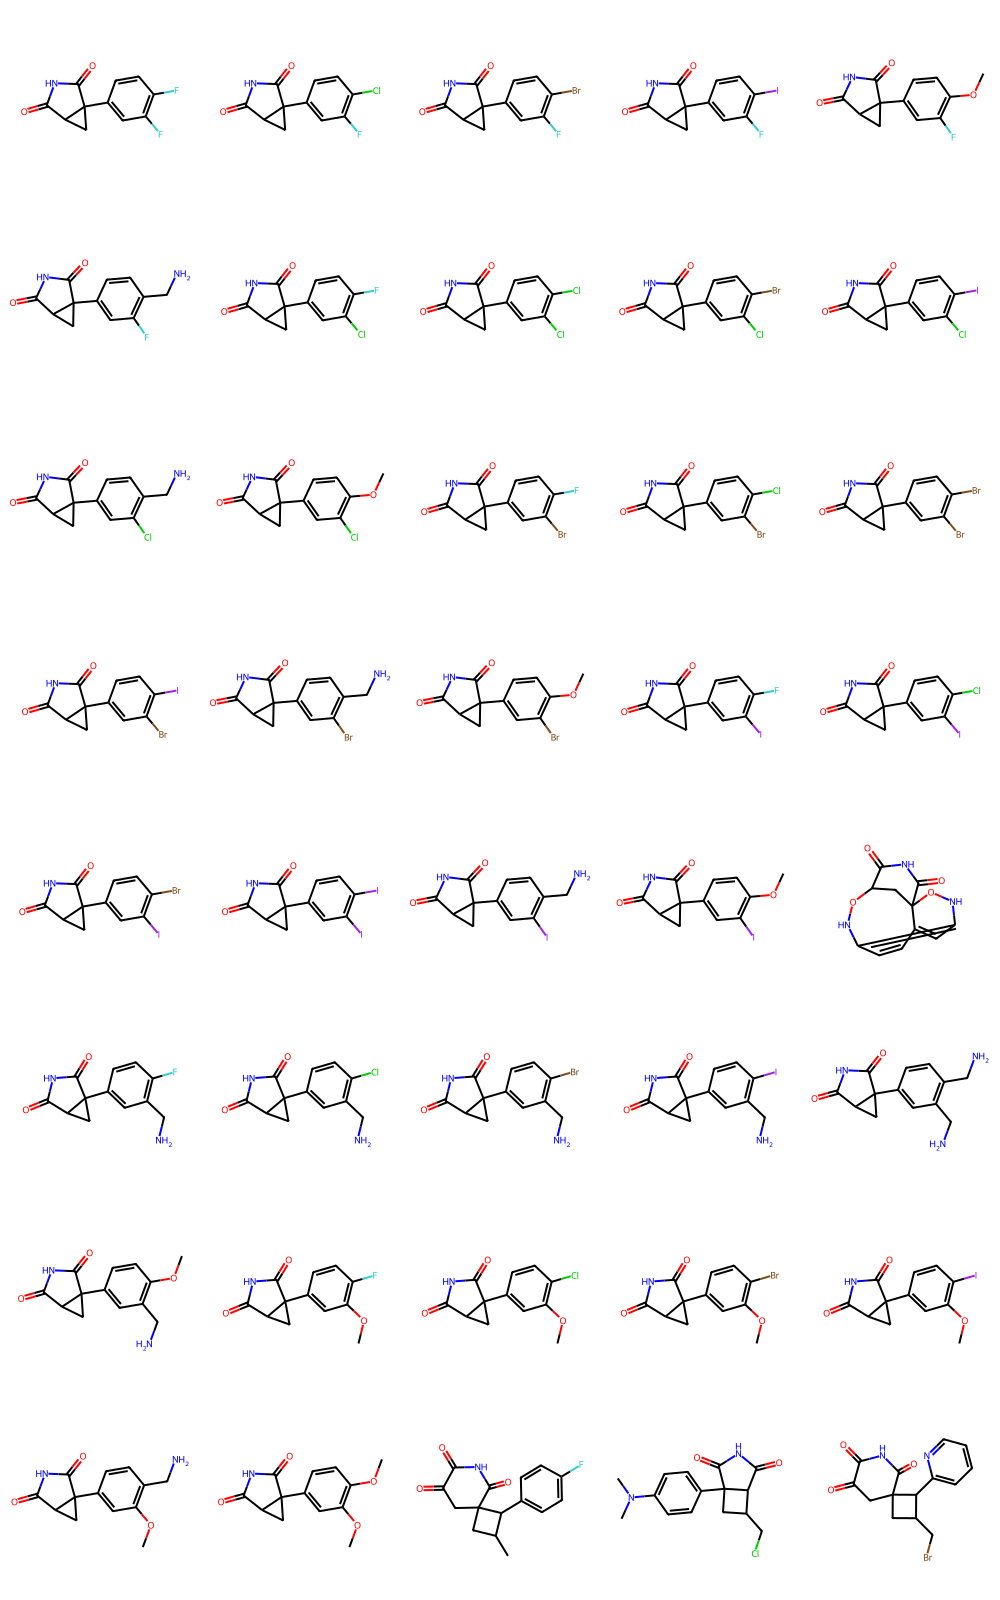

original data length: 144
train length: 115
test length: 29
charset length: 41
data signature: 144_42_41
Saved one-hot encoded CSV to data/ohe_data_train_144_42_41.csv
Saved one-hot encoded CSV to data/ohe_data_test_144_42_41.csv
Processing key: charset
Saved charset to data/processed_144_42_41.h5, shape: (41,)
Processing key: data_train
Saved data_train to data/processed_144_42_41.h5, shape: (115, 42, 41)
Processing key: data_test
Saved data_test to data/processed_144_42_41.h5, shape: (29, 42, 41)

Original: O=C1NC(=O)C2(c3cc(F)c(F)cc3)CC12
Predicted: C[C(@C(==CCC()C)C11c1cc1)C1C1CCO1

Original: O=C1NC(=O)C2(c3cc(F)c(Cl)cc3)CC12
Predicted: O=C1NC(=O/c2cccccCCCC(c2CC)cc221

Original: O=C1NC(=O)C2(c3cc(F)c(Br)cc3)CC12
Predicted: C=C(@](C/(C((((c2ccc(c)ccc2)CcCCC1

Original: O=C1NC(=O)C2(c3cc(F)c(I)cc3)CC12
Predicted: C=C@@](=/(C(((cc1ccc(c1cc)N)C1CCC1

Original: O=C1NC(=O)C2(c3cc(F)c(CH3)cc3)CC12
Predicted: O=C1=C(=C/C((c(cc(ClCC2))cc222

Original: O=C1NC(=O)C2(c3cc(F)c(CF3)cc3)CC12
Pre

In [18]:
if EVAL_OTHER_SMILES:
    smiles_file_path = 'data/SMILES_Dataset.csv'
    display_sample_smiles(smiles_file_path)